# Structured hierarchical models

The goal of this project is to model essential genes for multiple conditions given that we have prior knowledge about functional relations of these genes. The model we want to use is:

\begin{align}
\mathbf{z} & \sim \text{MRF} \\
\tau^2 & \sim P(\cdot) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \text{Lognormal}(1, 1) \\
x_{svg} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vg} \cdot \exp \left( \beta_{vg} \right) \right) \\
\end{align}

Alternatively, for normal data:
\begin{align}
\mathbf{z} & \sim \text{MRF} \\
\tau_g^2 & \sim \text{Gamma}(1, 1) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2) \\
\tau_b^2 & \sim \text{Gamma}(1, 1) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \mathcal{N}(0, 1) \\
\sigma & \sim \text{Gamma}(.5, .5) \\
x_{svg} \mid \beta_{vg} &  \sim  \mathcal{N}\left(l_{vg} + \beta_{vg}, \sigma^2 \right) \\
\end{align}

We start with some simple models, see them in the other notebooks.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
import pandas as pd
import pymc3 as pm
import numpy as np
import scipy as sp
import theano.tensor as tt

In [3]:
from sklearn.preprocessing import LabelEncoder
from pymc3 import  model_to_graphviz

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az

sns.set_style(
    "white", 
    {'xtick.bottom': True,
     'ytick.left': True,
     'axes.spines.top': False, 
     'axes.spines.right': False})

Since the MRF is particularly hard to estimate, we make use of a simpler representation first.

\begin{align}
\boldsymbol \pi & \sim \text{Dirichlet}(1, 1) \\
z_g & \sim \text{Categorical}(\boldsymbol \pi) \\
\tau_g^2 & \sim \text{Gamma}(1, 1) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau_g^2) \\
\tau_b^2 & \sim \text{Gamma}(1, 1) \\
\beta_{cg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau_b^2) \\
l_{cgs} & \sim \text{Lognormal}(1, 1) \\
x_{cgs} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vgs} \cdot \exp \left( \beta_{cg} \right) \right) \\
\end{align}

## Data

Since it is always _both_ replicates that have a low read count, it is safe to assume that these are no batch effects.

In [5]:
infile = "../data_raw/read_counts-normalized.tsv"

In [6]:
def _load_data(infile, normalize=False):    
    dat = pd.read_csv(infile, sep="\t")
    if normalize:
        dat["cm"] = np.mean(dat[["c1", "c2"]].values, axis=1)
        dat["r1"] = np.log(dat["r1"].values / dat["cm"].values)
        dat["r2"] = np.log(dat["r2"].values / dat["cm"].values)
#    dat = dat.query("Gene == 'BCR' | Gene == 'PSMB1'")
    dat = (dat[["Condition", "Gene", "sgRNA", "r1", "r2"]]
           .query("Gene != 'Control'")
           .melt(id_vars=["Gene", "Condition", "sgRNA"],
                 value_vars=["r1", "r2"],
                 var_name="replicate",
                 value_name="counts")
           .sort_values(["Gene", "Condition", "sgRNA", "replicate"])
    )
    dat["sgRNA"] = LabelEncoder().fit_transform(dat["sgRNA"].values)
    if not normalize:
        dat["counts"] = sp.floor(dat["counts"].values)
    return dat

In [7]:
read_counts = _load_data(infile, True)

## Inference

In [8]:
n, _ = read_counts.shape
le = LabelEncoder()

gene_idx = le.fit_transform(read_counts["Gene"].values)
con_idx = le.fit_transform(read_counts["Condition"].values)

len_genes = len(sp.unique(gene_idx))
len_conditions = len(sp.unique(con_idx))
len_sirnas = len(sp.unique(read_counts["sgRNA"].values))
len_replicates = len(sp.unique(read_counts["replicate"].values))
len_sirnas_per_gene = int(len_sirnas / len_genes)

beta_idx = np.tile(range(len_genes), len_conditions)
beta_data_idx = np.repeat(beta_idx, int(n / len(beta_idx)))

l_idx = np.repeat(range(len_sirnas), len_replicates )

In [36]:
with pm.Model() as model:
    p = pm.Dirichlet("p", a=np.array([0.5, 0.5]), shape=2)
    pm.Potential("p_pot", tt.switch(tt.min(p) < 0.05, -np.inf, 0))
    category = pm.Categorical("category", p=p, shape=len_genes)

    tau_g = pm.Gamma("tau_g", .1, .1, shape=1)
    mean_g = pm.Normal("mu_g", mu=np.array([0, 0]), sd=0.5, shape=2)
    pm.Potential("m_opot", tt.switch(mean_g[1] - mean_g[0] < 0, -np.inf, 0))
    gamma = pm.Normal("gamma", mean_g[category], tau_g, shape=len_genes)

    tau_b = pm.Gamma("tau_b", .1, .1, shape=1)
    if len_conditions == 1:
        beta = pm.Deterministic("beta", gamma)
    else:
        beta_non = pm.Normal('beta_non', 0, 1, shape= len(beta_idx))
        beta = pm.Deterministic("beta", gamma[beta_idx] + tau_b * beta_non)
    l = pm.Normal("l", 0, .25, shape=len_sirnas * 2)

    pm.Normal(
      "x",
      mu =      beta[beta_data_idx] + l[l_idx],
      observed = sp.squeeze(read_counts["counts"].values),
    )

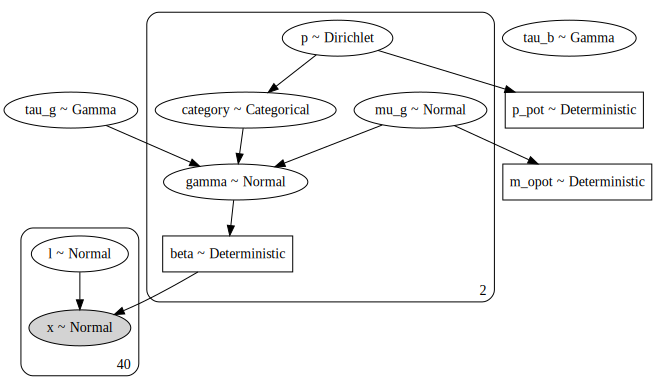

In [37]:
model_to_graphviz(model)

In [12]:
with model:
    trace = pm.sample(1000, n_init=10000, tune=100, chains=2, seed=23)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [l, tau_b, gamma, mu_g, tau_g, p]
>BinaryGibbsMetropolis: [category]
Sampling 2 chains: 100%|██████████| 2200/2200 [00:51<00:00, 43.09draws/s]
There were 938 divergences after tuning. Increase `target_accept` or reparameterize.
There were 877 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6986743898207757, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [39]:
az.rhat(trace)

<xarray.Dataset>
Dimensions:         (beta_dim_0: 4, category_dim_0: 4, gamma_dim_0: 4, l_dim_0: 80, mu_g_dim_0: 2, p_dim_0: 2, tau_b_dim_0: 1, tau_g_dim_0: 1)
Coordinates:
  * category_dim_0  (category_dim_0) int64 0 1 2 3
  * mu_g_dim_0      (mu_g_dim_0) int64 0 1
  * gamma_dim_0     (gamma_dim_0) int64 0 1 2 3
  * l_dim_0         (l_dim_0) int64 0 1 2 3 4 5 6 7 ... 72 73 74 75 76 77 78 79
  * p_dim_0         (p_dim_0) int64 0 1
  * tau_g_dim_0     (tau_g_dim_0) int64 0
  * tau_b_dim_0     (tau_b_dim_0) int64 0
  * beta_dim_0      (beta_dim_0) int64 0 1 2 3
Data variables:
    category        (category_dim_0) float64 1.15 1.15 1.15 1.13
    mu_g            (mu_g_dim_0) float64 1.24 1.22
    gamma           (gamma_dim_0) float64 1.08 1.13 1.07 1.1
    l               (l_dim_0) float64 1.32 1.01 1.0 1.01 ... 1.05 1.01 1.04 1.33
    p               (p_dim_0) float64 1.16 1.16
    tau_g           (tau_g_dim_0) float64 1.1
    tau_b           (tau_b_dim_0) float64 1.01
    beta           

In [40]:
az.effective_sample_size(trace)

<xarray.Dataset>
Dimensions:         (beta_dim_0: 4, category_dim_0: 4, gamma_dim_0: 4, l_dim_0: 80, mu_g_dim_0: 2, p_dim_0: 2, tau_b_dim_0: 1, tau_g_dim_0: 1)
Coordinates:
  * category_dim_0  (category_dim_0) int64 0 1 2 3
  * mu_g_dim_0      (mu_g_dim_0) int64 0 1
  * gamma_dim_0     (gamma_dim_0) int64 0 1 2 3
  * l_dim_0         (l_dim_0) int64 0 1 2 3 4 5 6 7 ... 72 73 74 75 76 77 78 79
  * p_dim_0         (p_dim_0) int64 0 1
  * tau_g_dim_0     (tau_g_dim_0) int64 0
  * tau_b_dim_0     (tau_b_dim_0) int64 0
  * beta_dim_0      (beta_dim_0) int64 0 1 2 3
Data variables:
    category        (category_dim_0) float64 16.0 15.0 15.0 15.0
    mu_g            (mu_g_dim_0) float64 5.0 7.0
    gamma           (gamma_dim_0) float64 14.0 14.0 110.0 15.0
    l               (l_dim_0) float64 6.0 213.0 244.0 229.0 ... 212.0 259.0 6.0
    p               (p_dim_0) float64 13.0 13.0
    tau_g           (tau_g_dim_0) float64 20.0
    tau_b           (tau_b_dim_0) float64 595.0
    beta          

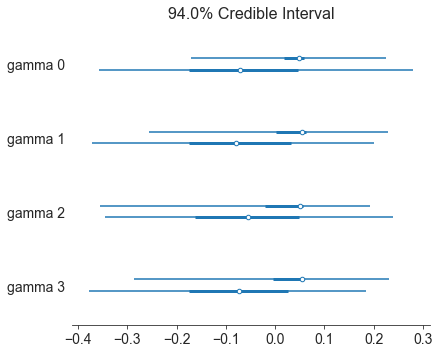

In [41]:
az.plot_forest(trace, var_names="gamma");

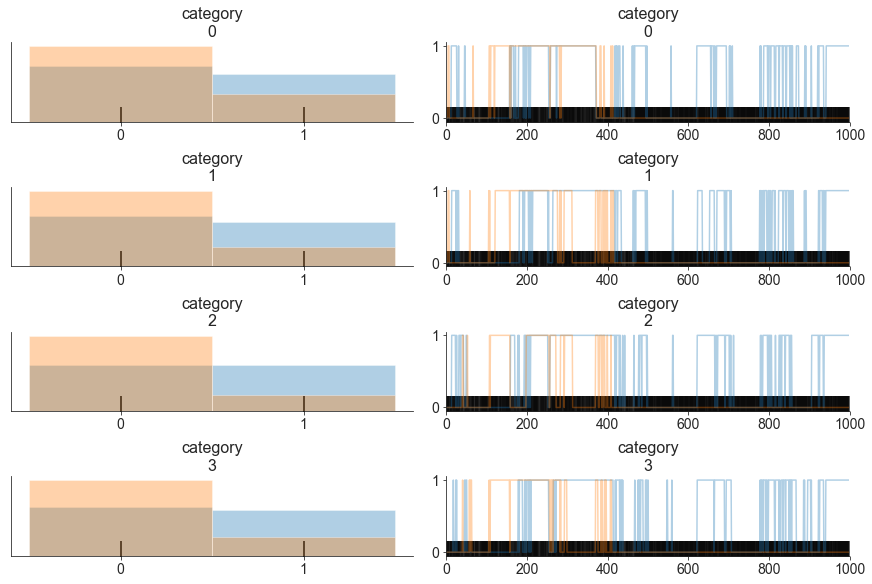

In [42]:
az.plot_trace(trace, var_names="category");

In [13]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace, 5000, random_seed=23)

100%|██████████| 5000/5000 [00:03<00:00, 1291.01it/s]


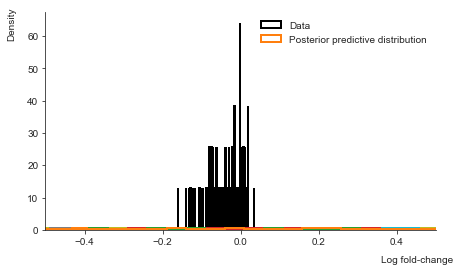

In [22]:

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(read_counts["counts"].values, bins=200, lw=2,
        density=True, edgecolor='black', histtype='step',
       label='Data');
ax.hist(ppc_trace['x'], bins=200, density=True, lw=2, histtype='step',
        label='Posterior predictive distribution');
ax.set_xlim([-.5, .5])
ax.set_xlabel(r"Log fold-change")
ax.set_ylabel(r"Density")
ax.xaxis.set_label_coords(.95, -0.115)
ax.yaxis.set_label_coords(-0.075, .95)
ax.set_xlim([-.5, .5])
ax.legend(frameon=False);

# Load a model

In [9]:
# %load "models.py"
import pandas as pd
import pymc3 as pm
import scipy as sp
import theano.tensor as tt
from sklearn.preprocessing import LabelEncoder


def shm(read_counts: pd.DataFrame, normalize):
    n, _ = read_counts.shape
    le = LabelEncoder()

    conditions = sp.unique(read_counts["Condition"].values)
    genes = sp.unique(read_counts["Gene"].values)
    gene_idx = le.fit_transform(read_counts["Gene"].values)
    con_idx = le.fit_transform(read_counts["Condition"].values)

    len_genes = len(sp.unique(gene_idx))
    len_conditions = len(sp.unique(con_idx))
    len_sirnas = len(sp.unique(read_counts["sgRNA"].values))
    len_replicates = len(sp.unique(read_counts["replicate"].values))
    len_sirnas_per_gene = int(len_sirnas / len_genes)

    beta_idx = sp.repeat(range(len_genes), len_conditions)
    beta_data_idx = sp.repeat(beta_idx, int(n / len(beta_idx)))

    con = conditions[sp.repeat(sp.unique(con_idx), len_genes)]
    gene_conds = ["{}-{}".format(a, b) for a, b in zip(genes[beta_idx], con)]

    l_idx = sp.repeat(
      range(len_genes * len_conditions * len_sirnas_per_gene), len_replicates)

    with pm.Model() as model:
        p = pm.Dirichlet("p", a=sp.array([1.0, 1.0]), shape=2)
        pm.Potential("p_pot", tt.switch(tt.min(p) < 0.05, -sp.inf, 0))
        category = pm.Categorical("category", p=p, shape=len_genes)

        tau_g = pm.Gamma("tau_g", 1.0, 1.0, shape=1)
        mean_g = pm.Normal("mu_g", mu=sp.array([0, 0]), sd=0.5, shape=2)
        pm.Potential("m_opot", tt.switch(mean_g[1] - mean_g[0] < 0, -sp.inf, 0))
        gamma = pm.Normal("gamma", mean_g[category], tau_g, shape=len_genes)

        tau_b = pm.Gamma("tau_b", 1.0, 1.0, shape=1)
        if len_conditions == 1:
            beta = pm.Deterministic("beta", gamma)
        else:
            beta = pm.Normal("beta", gamma[beta_idx], tau_b,
                             shape=len(beta_idx))

        if normalize:
            l = pm.Normal("l", 0, 0.25, shape=len_sirnas)
            pm.Normal(
              "x",
              mu= beta[beta_data_idx] + l[l_idx],
              observed=sp.squeeze(read_counts["counts"].values),
            )
        else:
            l = pm.Lognormal("l", 0, 0.25, shape=len_sirnas)
            pm.Poisson(
              "x",
              mu=sp.exp(beta[beta_data_idx]) * l[l_idx],
              observed=sp.squeeze(read_counts["counts"].values))

    return model, genes, gene_conds


def shm_independent_l(read_counts: pd.DataFrame, normalize):
    n, _ = read_counts.shape
    le = LabelEncoder()

    conditions = sp.unique(read_counts["Condition"].values)
    genes = sp.unique(read_counts["Gene"].values)
    gene_idx = le.fit_transform(read_counts["Gene"].values)
    con_idx = le.fit_transform(read_counts["Condition"].values)

    len_genes = len(sp.unique(gene_idx))
    len_conditions = len(sp.unique(con_idx))

    beta_idx = sp.repeat(range(len_genes), len_conditions)
    beta_data_idx = sp.repeat(beta_idx, int(n / len(beta_idx)))

    con = conditions[sp.repeat(sp.unique(con_idx), len_genes)]
    gene_conds = ["{}-{}".format(a, b) for a, b in zip(genes[beta_idx], con)]

    with pm.Model() as model:
        p = pm.Dirichlet("p", a=sp.array([1.0, 1.0]), shape=2)
        pm.Potential("p_pot", tt.switch(tt.min(p) < 0.05, -sp.inf, 0))
        category = pm.Categorical("category", p=p, shape=len_genes)

        tau_g = pm.Gamma("tau_g", 1.0, 1.0, shape=1)
        mean_g = pm.Normal("mu_g", mu=sp.array([0, 0]), sd=0.5, shape=2)
        pm.Potential("m_opot", tt.switch(mean_g[1] - mean_g[0] < 0, -sp.inf, 0))
        gamma = pm.Normal("gamma", mean_g[category], tau_g, shape=len_genes)

        tau_b = pm.Gamma("tau_b", 1.0, 1.0, shape=1)
        if len_conditions == 1:
            beta = pm.Deterministic("beta", gamma)
        else:
            beta = pm.Normal("beta", gamma[beta_idx], tau_b,
                             shape=len(beta_idx))

        if normalize:
            l = pm.Normal("l", 0, 0.25, shape=n)
            pm.Normal(
              "x",
              mu= beta[beta_data_idx] + l,
              observed=sp.squeeze(read_counts["counts"].values),
            )
        else:
            l = pm.Lognormal("l", 0, 0.25, shape=n)
            pm.Poisson(
              "x",
              mu=sp.exp(beta[beta_data_idx]) * l,
              observed=sp.squeeze(read_counts["counts"].values))

    return model, genes, gene_conds


def shm_no_clustering(read_counts: pd.DataFrame, normalize):
    n, _ = read_counts.shape
    le = LabelEncoder()

    conditions = sp.unique(read_counts["Condition"].values)
    genes = sp.unique(read_counts["Gene"].values)
    gene_idx = le.fit_transform(read_counts["Gene"].values)
    con_idx = le.fit_transform(read_counts["Condition"].values)

    len_genes = len(sp.unique(gene_idx))
    len_conditions = len(sp.unique(con_idx))
    len_sirnas = len(sp.unique(read_counts["sgRNA"].values))
    len_replicates = len(sp.unique(read_counts["replicate"].values))
    len_sirnas_per_gene = int(len_sirnas / len_genes)

    beta_idx = sp.repeat(range(len_genes), len_conditions)
    beta_data_idx = sp.repeat(beta_idx, int(n / len(beta_idx)))

    con = conditions[sp.repeat(sp.unique(con_idx), len_genes)]
    gene_conds = ["{}-{}".format(a, b) for a, b in zip(genes[beta_idx], con)]

    l_idx = sp.repeat(
      range(len_genes * len_conditions * len_sirnas_per_gene), len_replicates)

    with pm.Model() as model:
        tau_g = pm.Gamma("tau_g", 1.0, 1.0, shape=1)
        gamma = pm.Normal("gamma", 0, tau_g, shape=len_genes)

        tau_b = pm.Gamma("tau_b", 1.0, 1.0, shape=1)
        if len_conditions == 1:
            beta = pm.Deterministic("beta", gamma)
        else:
            beta = pm.Normal("beta", gamma[beta_idx], tau_b,
                             shape=len(beta_idx))

        if normalize:
            l = pm.Normal("l", 0, 0.25, shape=len_sirnas)
            pm.Normal(
              "x",
              mu= beta[beta_data_idx] + l[l_idx],
              observed=sp.squeeze(read_counts["counts"].values),
            )
        else:
            l = pm.Lognormal("l", 0, 0.25, shape=len_sirnas)
            pm.Poisson(
              "x",
              mu=sp.exp(beta[beta_data_idx]) * l[l_idx],
              observed=sp.squeeze(read_counts["counts"].values))

    return model, genes, gene_conds


def shm_no_clustering_independent_l(read_counts: pd.DataFrame, normalize):
    n, _ = read_counts.shape
    le = LabelEncoder()

    conditions = sp.unique(read_counts["Condition"].values)
    genes = sp.unique(read_counts["Gene"].values)
    gene_idx = le.fit_transform(read_counts["Gene"].values)
    con_idx = le.fit_transform(read_counts["Condition"].values)

    len_genes = len(sp.unique(gene_idx))
    len_conditions = len(sp.unique(con_idx))

    beta_idx = sp.repeat(range(len_genes), len_conditions)
    beta_data_idx = sp.repeat(beta_idx, int(n / len(beta_idx)))

    con = conditions[sp.repeat(sp.unique(con_idx), len_genes)]
    gene_conds = ["{}-{}".format(a, b) for a, b in zip(genes[beta_idx], con)]

    with pm.Model() as model:
        tau_g = pm.Gamma("tau_g", 1.0, 1.0, shape=1)
        gamma = pm.Normal("gamma", 0, tau_g, shape=len_genes)

        tau_b = pm.Gamma("tau_b", 1.0, 1.0, shape=1)
        if len_conditions == 1:
            beta = pm.Deterministic("beta", gamma)
        else:
            beta = pm.Normal("beta", gamma[beta_idx], tau_b,
                             shape=len(beta_idx))

        if normalize:
            l = pm.Normal("l", 0, 0.25, shape=n)
            pm.Normal(
              "x",
              mu= beta[beta_data_idx] + l,
              observed=sp.squeeze(read_counts["counts"].values),
            )
        else:
            l = pm.Lognormal("l", 0, 0.25, shape=n)
            pm.Poisson(
              "x",
              mu=sp.exp(beta[beta_data_idx]) * l,
              observed=sp.squeeze(read_counts["counts"].values))

    return model, genes, gene_conds


In [160]:
model, _, _ = shm_no_clustering(read_counts, True)

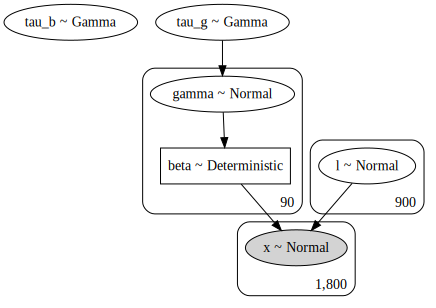

In [11]:
model_to_graphviz(model)

In [161]:
with model:
    trace2 = pm.load_trace('/Users/simondi/PROJECTS/cell_line_project/results/shm/2019_03_18/shm_no_clust_normalize/model_trace')

In [105]:
# %load plot.py
import numpy as np
import pandas as pd
from arviz import convert_to_dataset
from arviz.plots.plot_utils import xarray_to_ndarray, get_coords

from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az

sns.set_style(
  "white",
  {
      "xtick.bottom": True,
      "ytick.left": True,
      "axes.spines.top": False,
      "axes.spines.right": False,
  },
)


def _plot_dotline(table, boundary, var, low, mid, high, legend, title, xlabel, xlim):
    fig, ax = plt.subplots(figsize=(5, 3), dpi=720)

    plt.axvline(x=boundary[0], color="grey", linestyle="--", linewidth=.5)
    plt.axvline(x=boundary[1], color="grey", linestyle="--", linewidth=.5)
    plt.axvline(x=boundary[2], color="grey", linestyle="--", linewidth=.5)

    plt.hlines(y=table["param"].values[low],
               xmin=xlim, xmax=table[var].values[low],
               linewidth=.5, color="#023858")
    plt.hlines(y=table["param"].values[mid],
               xmin=xlim, xmax=table[var].values[mid],
               linewidth=.5, color="#045a8d")
    plt.hlines(y=table["param"].values[high],
               xmin=xlim, xmax=table[var].values[high],
               linewidth=.5, color="#74a9cf")

    plt.plot(table[var].values[low], table["param"].values[low],
             "o", markersize=3, color="#023858",
             label="${} < {}$".format(legend, boundary[0]))
    plt.plot(table[var].values[mid], table["param"].values[mid],
             "o", markersize=3, color="#045a8d",
             label="${} < {}$".format(legend, boundary[1]))
    plt.plot(table[var].values[high], table["param"].values[high],
             "o", markersize=3, color="#74a9cf",
             label="${} >= {}$".format(legend, boundary[1]))

    plt.title(title, loc="Left")
    plt.legend(bbox_to_anchor=(1.0, 0.5), loc="center left", frameon=False)
    plt.xlabel(xlabel)
    plt.ylabel("Parameters")
    plt.tick_params(axis=None)
    plt.xlim(left=xlim)
    plt.tight_layout()
    return fig, ax


def plot_neff(trace, var_name, variable=None):
    eff_samples = (az.effective_sample_size(trace)[var_name]).to_dataframe()
    boundary = [0.1, 0.5, 1]
    eff_samples = pd.DataFrame({
        "neff": eff_samples[var_name].values / (len(trace) * 4),
        "param": [var_name + str(i) for i in range(len(eff_samples))]})
    if variable is not None:
        eff_samples["param"] = variable
    low = np.where(eff_samples["neff"].values < boundary[0])
    mid = np.where(np.logical_and(
      eff_samples["neff"].values >= boundary[0],
      eff_samples["neff"].values < boundary[1]))
    high = np.where(eff_samples["neff"].values >= boundary[1])

    return _plot_dotline(eff_samples, boundary, "neff",
                         low, mid, high,
                         "n_eff / n", "Effective sample size", "n_eff / n",0)


def plot_rhat(trace, var_name, variable=None):
    rhat_samples = (az.rhat(trace)[var_name]).to_dataframe()
    boundary = [1.05, 1.1, 1.5]
    rhat_samples = pd.DataFrame({
        "rhat": rhat_samples[var_name].values,
        "param": [var_name + str(i) for i in range(len(rhat_samples))]})
    if variable is not None:
        rhat_samples["param"] = variable
    low = np.where(rhat_samples["rhat"].values < boundary[0])
    mid = np.where(np.logical_and(
      rhat_samples["rhat"].values >= boundary[0],
      rhat_samples["rhat"].values < boundary[1]))
    high = np.where(rhat_samples["rhat"].values >= boundary[1])

    return _plot_dotline(rhat_samples, boundary, "rhat",
                         low, mid, high, r"\hat{R}",
                         "Potential scale reduction factor", r"$\hat{R}$",
                         xlim=1)


def _to_df(trace, var_name, idx):
    n_chains = trace.nchains
    samples = trace.get_values(var_name)[:, idx]
    len_per_sample = int(len(samples) / n_chains)
    chains = np.repeat(trace.chains, len_per_sample) + 1
    frame = pd.DataFrame({
        'Chain': chains,
        'sample': samples,
        'idxx': np.tile(range(len_per_sample), n_chains)
    })

    return frame


def plot_trace(trace, var_name, ntune, keep_burnin, idx, title):
    frame = _to_df(trace, var_name, idx)

    fig, ax = plt.subplots(figsize=(7, 2.5), dpi=720)
    sns.lineplot(x="idxx", y="sample", data=frame, hue='Chain',
                 palette=sns.cubehelix_palette(4, start=.5, rot=-.75))
    if keep_burnin:
        plt.axvline(ntune, linestyle='--', linewidth=.5, color="grey")
        plt.annotate("Burn-in", (ntune, 0))
    plt.legend(title='Chain', bbox_to_anchor=(.95, 0.5), loc="center left",
               frameon=False, labels=['1', '2', '3', '4'])
    plt.xlabel("")
    plt.ylabel("")
    plt.title(title, loc="Left")

    return fig, ax


def plot_hist(trace, var_name, ntune, keep_burnin, idx, title):
    fr = _to_df(trace, var_name, idx)
    fr = fr[["sample", "Chain", "idxx"]].pivot(index="idxx", columns="Chain")
    fr = fr.values

    fig, ax = plt.subplots(figsize=(7, 2.5), dpi=720)
    cols = sns.cubehelix_palette(4, start=.5, rot=-.75).as_hex()
    if not keep_burnin:
        ntune = 0
    ax.hist(fr[ntune:, 0], 50, color=cols[0], label="1", alpha=.75)
    ax.hist(fr[ntune:, 1], 50, color=cols[1], label="2", alpha=.75)
    ax.hist(fr[ntune:, 2], 50, color=cols[2], label="3", alpha=.75)
    ax.hist(fr[ntune:, 3], 50, color=cols[3], label="4", alpha=.75)

    leg = plt.legend(title="Chain", bbox_to_anchor=(.95, 0.5),
                     loc="center left", frameon=False)
    leg._legend_box.align = "left"
    plt.xlabel("")
    plt.ylabel("")
    plt.title(title, loc="Left")

    return fig, ax


def _var_names(var_names, data):
    """Handle var_names input across arviz.
    Parameters
    ----------
    var_names: str, list, or None
    data : xarray.Dataset
        Posterior data in an xarray
    Returns
    -------
    var_name: list or None
    """
    if var_names is not None:

        if isinstance(var_names, str):
            var_names = [var_names]
        if isinstance(data, (list, tuple)):
            all_vars = []
            for dataset in data:
                dataset_vars = list(dataset.data_vars)
                for var in dataset_vars:
                    if var not in all_vars:
                        all_vars.append(var)
        else:
            all_vars = list(data.data_vars)
        excluded_vars = [i[1:] for i in var_names if i.startswith("~") and i not in all_vars]
        if excluded_vars:
            var_names = [i for i in all_vars if i not in excluded_vars]
    return var_names


def _extract(trace):
    divergent_data = convert_to_dataset(trace, group="sample_stats")
    _, diverging_mask = xarray_to_ndarray(
      divergent_data, var_names=("diverging",), combined=True)
    diverging_mask = np.squeeze(diverging_mask)

    posterior_data = convert_to_dataset(trace, group="posterior")
    var_names = _var_names(["beta", "gamma", "tau_b", "tau_g"], posterior_data)
    var_names, _posterior = xarray_to_ndarray(
      get_coords(posterior_data, {}), var_names=var_names, combined=True)
    return diverging_mask, var_names, _posterior


def plot_parallel(trace, ntune, nsample, keep_burnin):
    diverging_mask, var_names, _posterior = _extract(trace)
    var_names = [var.replace("\n", " ") for var in var_names]

    if not keep_burnin:
        ntune = 0
    n_all = ntune + np.maximum(100, nsample) - 1
    diverging_mask = diverging_mask[ntune:]
    _posterior = _posterior[:, ntune:]

    fig, ax = plt.subplots(figsize=(8, 4), dpi=720)
    ax.plot(_posterior[:, ~diverging_mask], color="black", alpha=0.025, lw=.25)

    if np.any(diverging_mask):
        ax.plot(_posterior[:, diverging_mask], color="darkred", lw=.25)

    ax.set_xticks(range(len(var_names)))
    ax.set_xticklabels(var_names)
    plt.xticks(rotation=90)
    ax.plot([], color="black", label="non-divergent")
    if np.any(diverging_mask):
        ax.plot([], color="darkred", label="divergent")
    ax.legend(frameon=False)
    plt.tight_layout()
    return fig, ax


def plot_data(read_counts):
    fig, ax = plt.subplots(figsize=(7, 4))
    plt.hist(read_counts["counts"].values, bins=300, color="darkgrey",
             density=True, edgecolor='black')
    ax.set_xlim([-.5, .5])
    ax.set_xlabel(r"Log fold-change")
    ax.set_ylabel(r"Density")
    ax.xaxis.set_label_coords(.95, -0.115)
    ax.yaxis.set_label_coords(-0.075, .95)

    return fig, ax


def plot_posterior(readcounts ,ppc_trace):
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.hist(readcounts["counts"].values, bins=200, lw=2,
            density=True, edgecolor='black', histtype='step', label='Data')
    ax.hist(ppc_trace['x'], bins=200, density=True, lw=2,
            histtype='step', label='Posterior predictive distribution');
    ax.set_xlim([-.5, .5])
    ax.set_xlabel(r"Log fold-change")
    ax.set_ylabel(r"Density")
    ax.xaxis.set_label_coords(.95, -0.115)
    ax.yaxis.set_label_coords(-0.075, .95)
    ax.set_xlim([-.5, .5])
    ax.legend(frameon=False)

    return fig, ax

In [114]:
def plot_data(read_counts):
    fig, ax = plt.subplots(figsize=(5, 3))
    plt.hist(read_counts["counts"].values, bins=500, color="darkgrey",
             density=True, edgecolor='black')
    ax.set_xlim([-.5, .5])
    ax.set_xlabel(r"Log fold-change")
    ax.set_ylabel(r"Density")
    ax.xaxis.set_label_coords(.95, -0.115)
    ax.yaxis.set_label_coords(-0.075, .95)

    return fig, ax

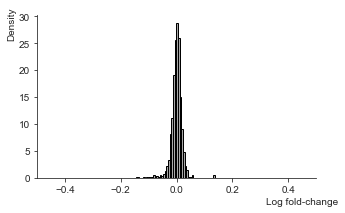

In [126]:
fig, ax = plot_data(read_counts)

In [127]:
fig.savefig("/Users/simondi/PHD/Sci/phd/presentations/2019_03_20_group_meeting/fig/data_histogram.svg")

In [135]:
def _plot_dotline(table, boundary, var, low, mid, high, legend, title, xlabel, xlim):
    fig, ax = plt.subplots(figsize=(5, 3), dpi=720)

    plt.axvline(x=boundary[0], color="grey", linestyle="--", linewidth=.5)
    plt.axvline(x=boundary[1], color="grey", linestyle="--", linewidth=.5)
    plt.axvline(x=boundary[2], color="grey", linestyle="--", linewidth=.5)

    plt.hlines(y=table["param"].values[low],
               xmin=xlim, xmax=table[var].values[low],
               linewidth=.5, color="#023858")
    plt.hlines(y=table["param"].values[mid],
               xmin=xlim, xmax=table[var].values[mid],
               linewidth=.5, color="#045a8d")
    plt.hlines(y=table["param"].values[high],
               xmin=xlim, xmax=table[var].values[high],
               linewidth=.5, color="#74a9cf")

    plt.plot(table[var].values[low], table["param"].values[low],
             "o", markersize=3, color="#023858",
             label="${} < {}$".format(legend, boundary[0]))
    plt.plot(table[var].values[mid], table["param"].values[mid],
             "o", markersize=3, color="#045a8d",
             label="${} < {}$".format(legend, boundary[1]))
    plt.plot(table[var].values[high], table["param"].values[high],
             "o", markersize=3, color="#74a9cf",
             label="${} \geq {}$".format(legend, boundary[1]))

    plt.title(title, loc="Left")
    plt.legend(bbox_to_anchor=(1.0, 0.5), loc="center left", frameon=False)
    plt.xlabel(xlabel)
    plt.ylabel("Parameters")
    plt.tick_params(axis='y', labelleft=None, left=None)
    plt.xlim(left=xlim)
    plt.tight_layout()
    return fig, ax

In [158]:
def plot_neff(trace, var_name, variable=None):
    eff_samples = (az.effective_sample_size(trace)[var_name]).to_dataframe()
    boundary = [0.1, 0.5, 1]
    eff_samples = pd.DataFrame({
        "neff": eff_samples[var_name].values / (len(trace) * 4),
        "param": [var_name + str(i) for i in range(len(eff_samples))]})
    if variable is not None:
        eff_samples["param"] = variable
    low = np.where(eff_samples["neff"].values < boundary[0])
    mid = np.where(np.logical_and(
      eff_samples["neff"].values >= boundary[0],
      eff_samples["neff"].values < boundary[1]))
    high = np.where(eff_samples["neff"].values >= boundary[1])

    return _plot_dotline(eff_samples, boundary, "neff",
                         low, mid, high,
                         "n_e / n", "Effective sample size", "$n_e / n$",0)

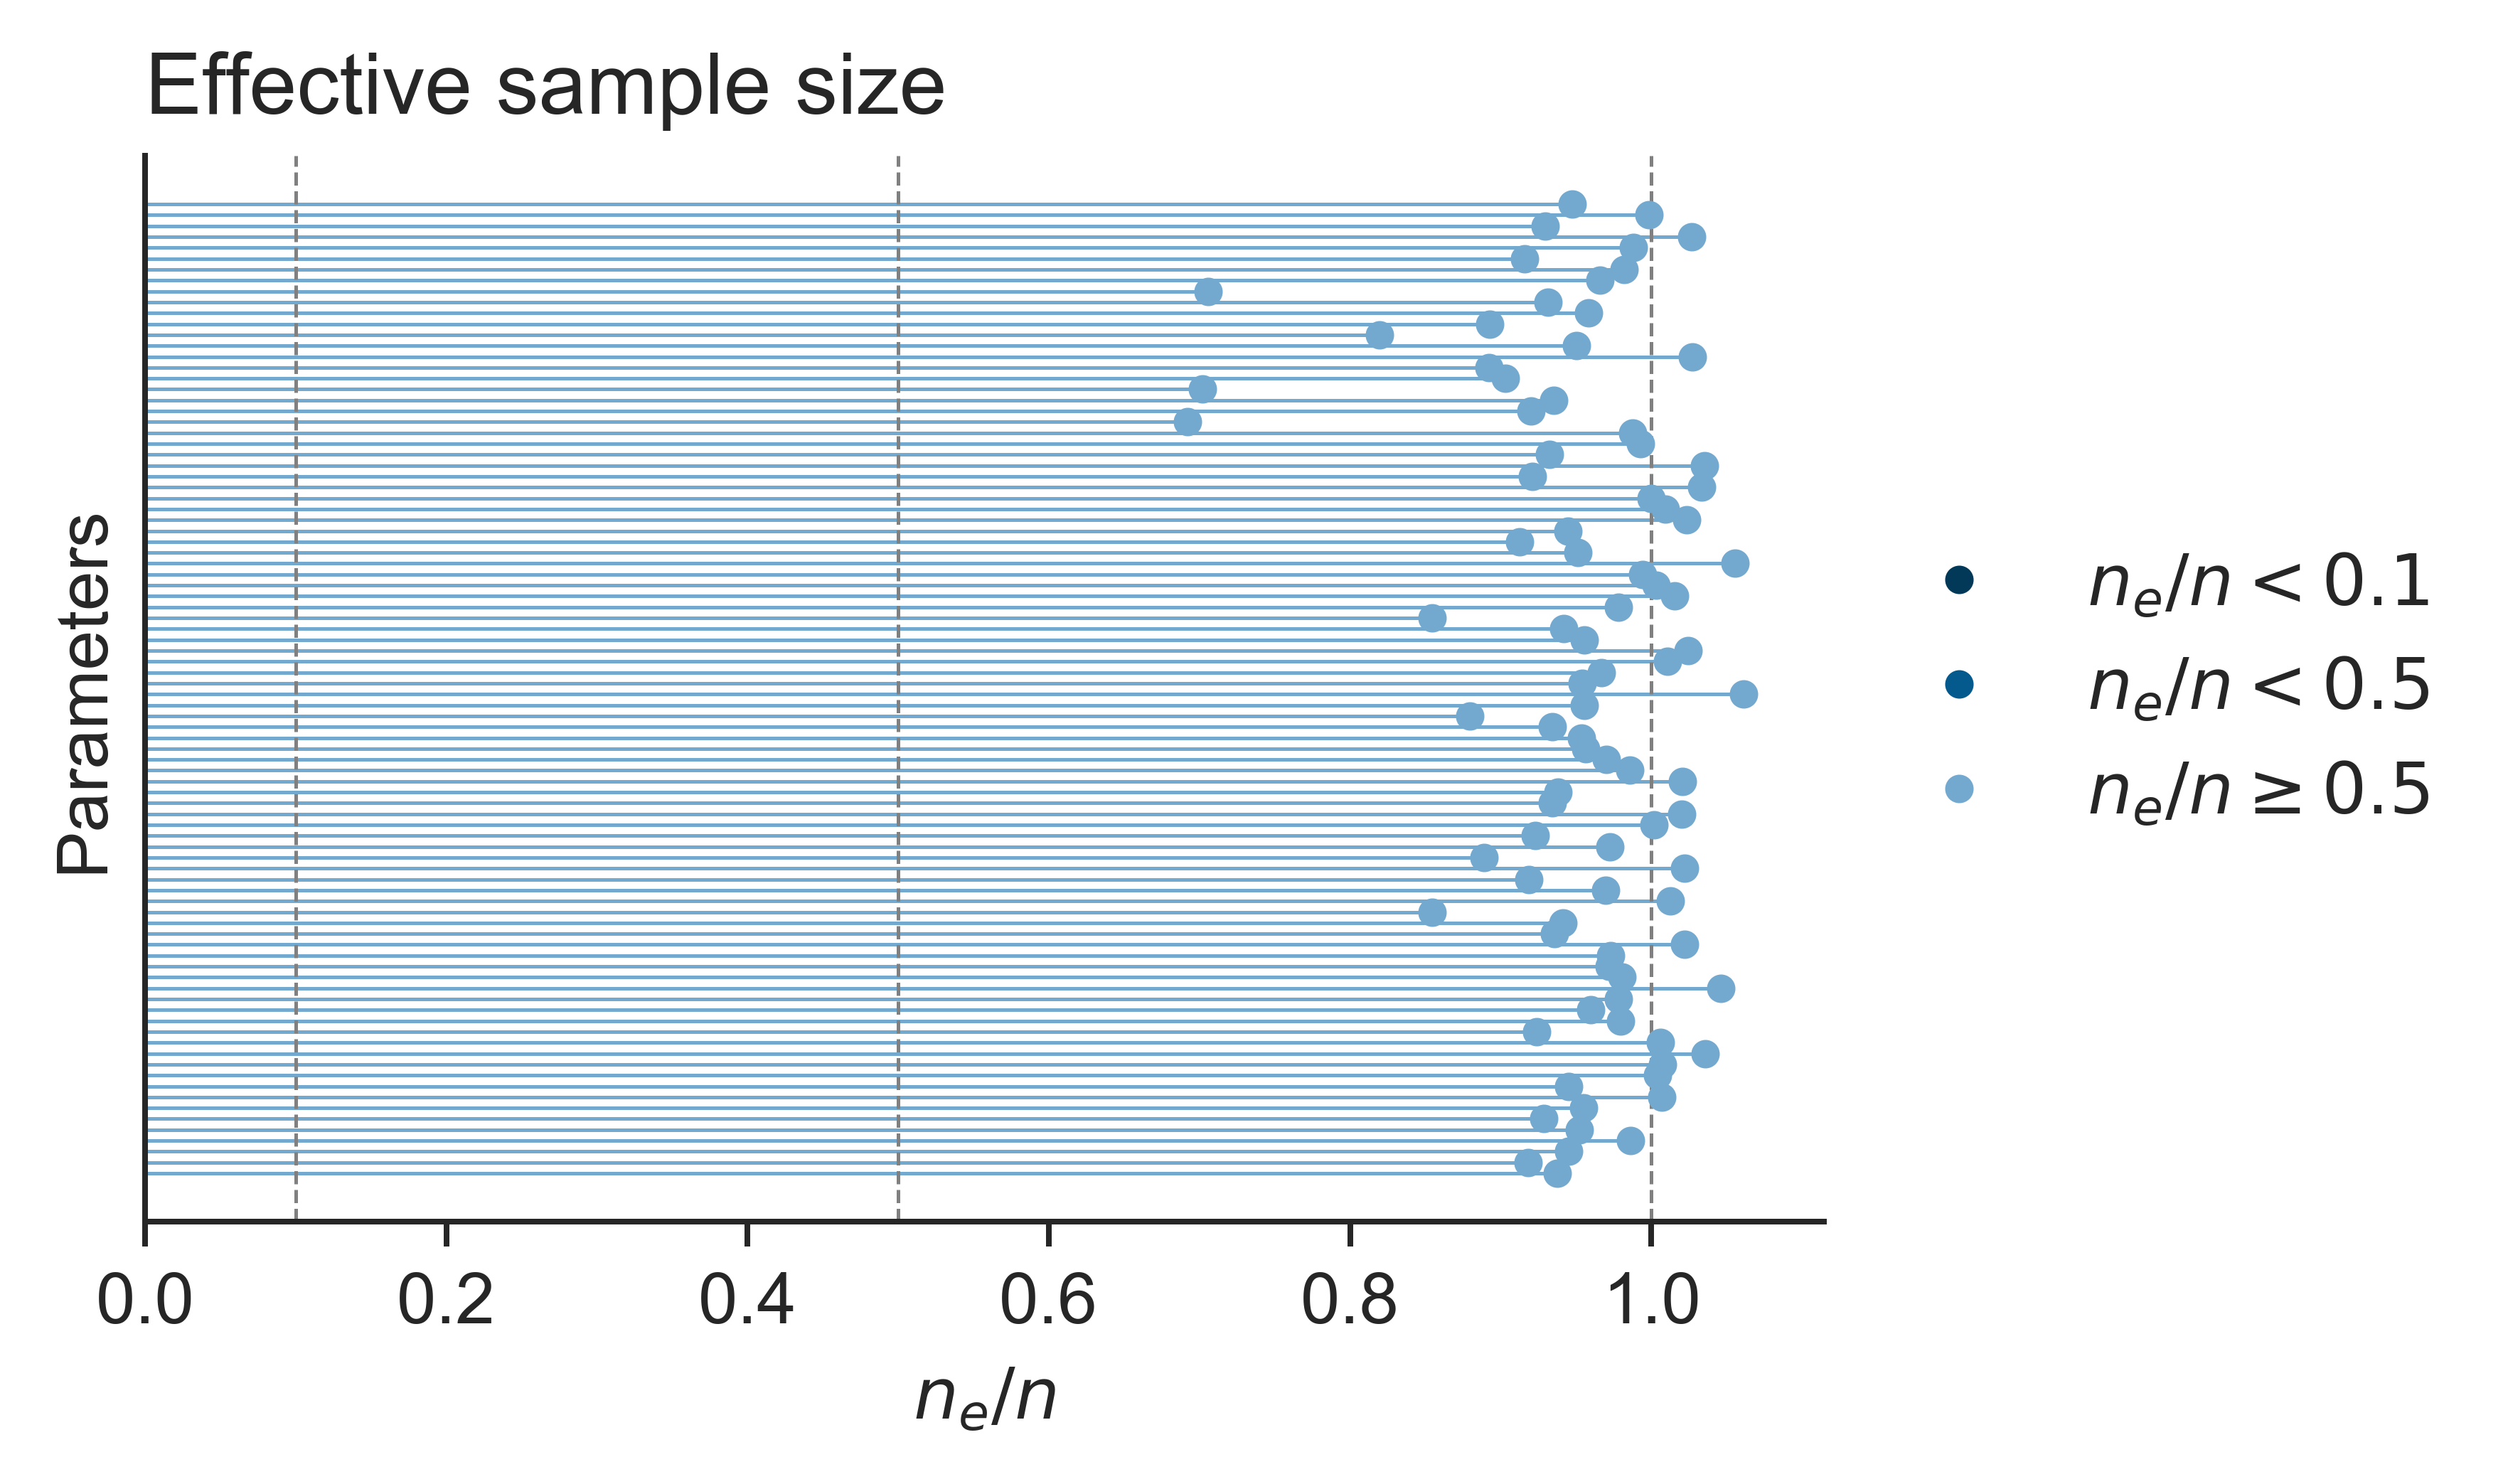

In [162]:
fig, ax = plot_neff(trace2, "gamma")

In [163]:
fig.savefig("/Users/simondi/PHD/Sci/phd/presentations/2019_03_20_group_meeting/fig/posterior_neff.svg")

In [131]:
def plot_rhat(trace, var_name, variable=None):
    rhat_samples = (az.rhat(trace)[var_name]).to_dataframe()
    boundary = [1.01, 1.05, 1.1]
    rhat_samples = pd.DataFrame({
        "rhat": rhat_samples[var_name].values,
        "param": [var_name + str(i) for i in range(len(rhat_samples))]})
    if variable is not None:
        rhat_samples["param"] = variable
    low = np.where(rhat_samples["rhat"].values < boundary[0])
    mid = np.where(np.logical_and(
      rhat_samples["rhat"].values >= boundary[0],
      rhat_samples["rhat"].values < boundary[1]))
    high = np.where(rhat_samples["rhat"].values >= boundary[1])

    return _plot_dotline(rhat_samples, boundary, "rhat",
                         low, mid, high, r"\hat{R}",
                         "Potential scale reduction factor", r"$\hat{R}$",
                         xlim=1)

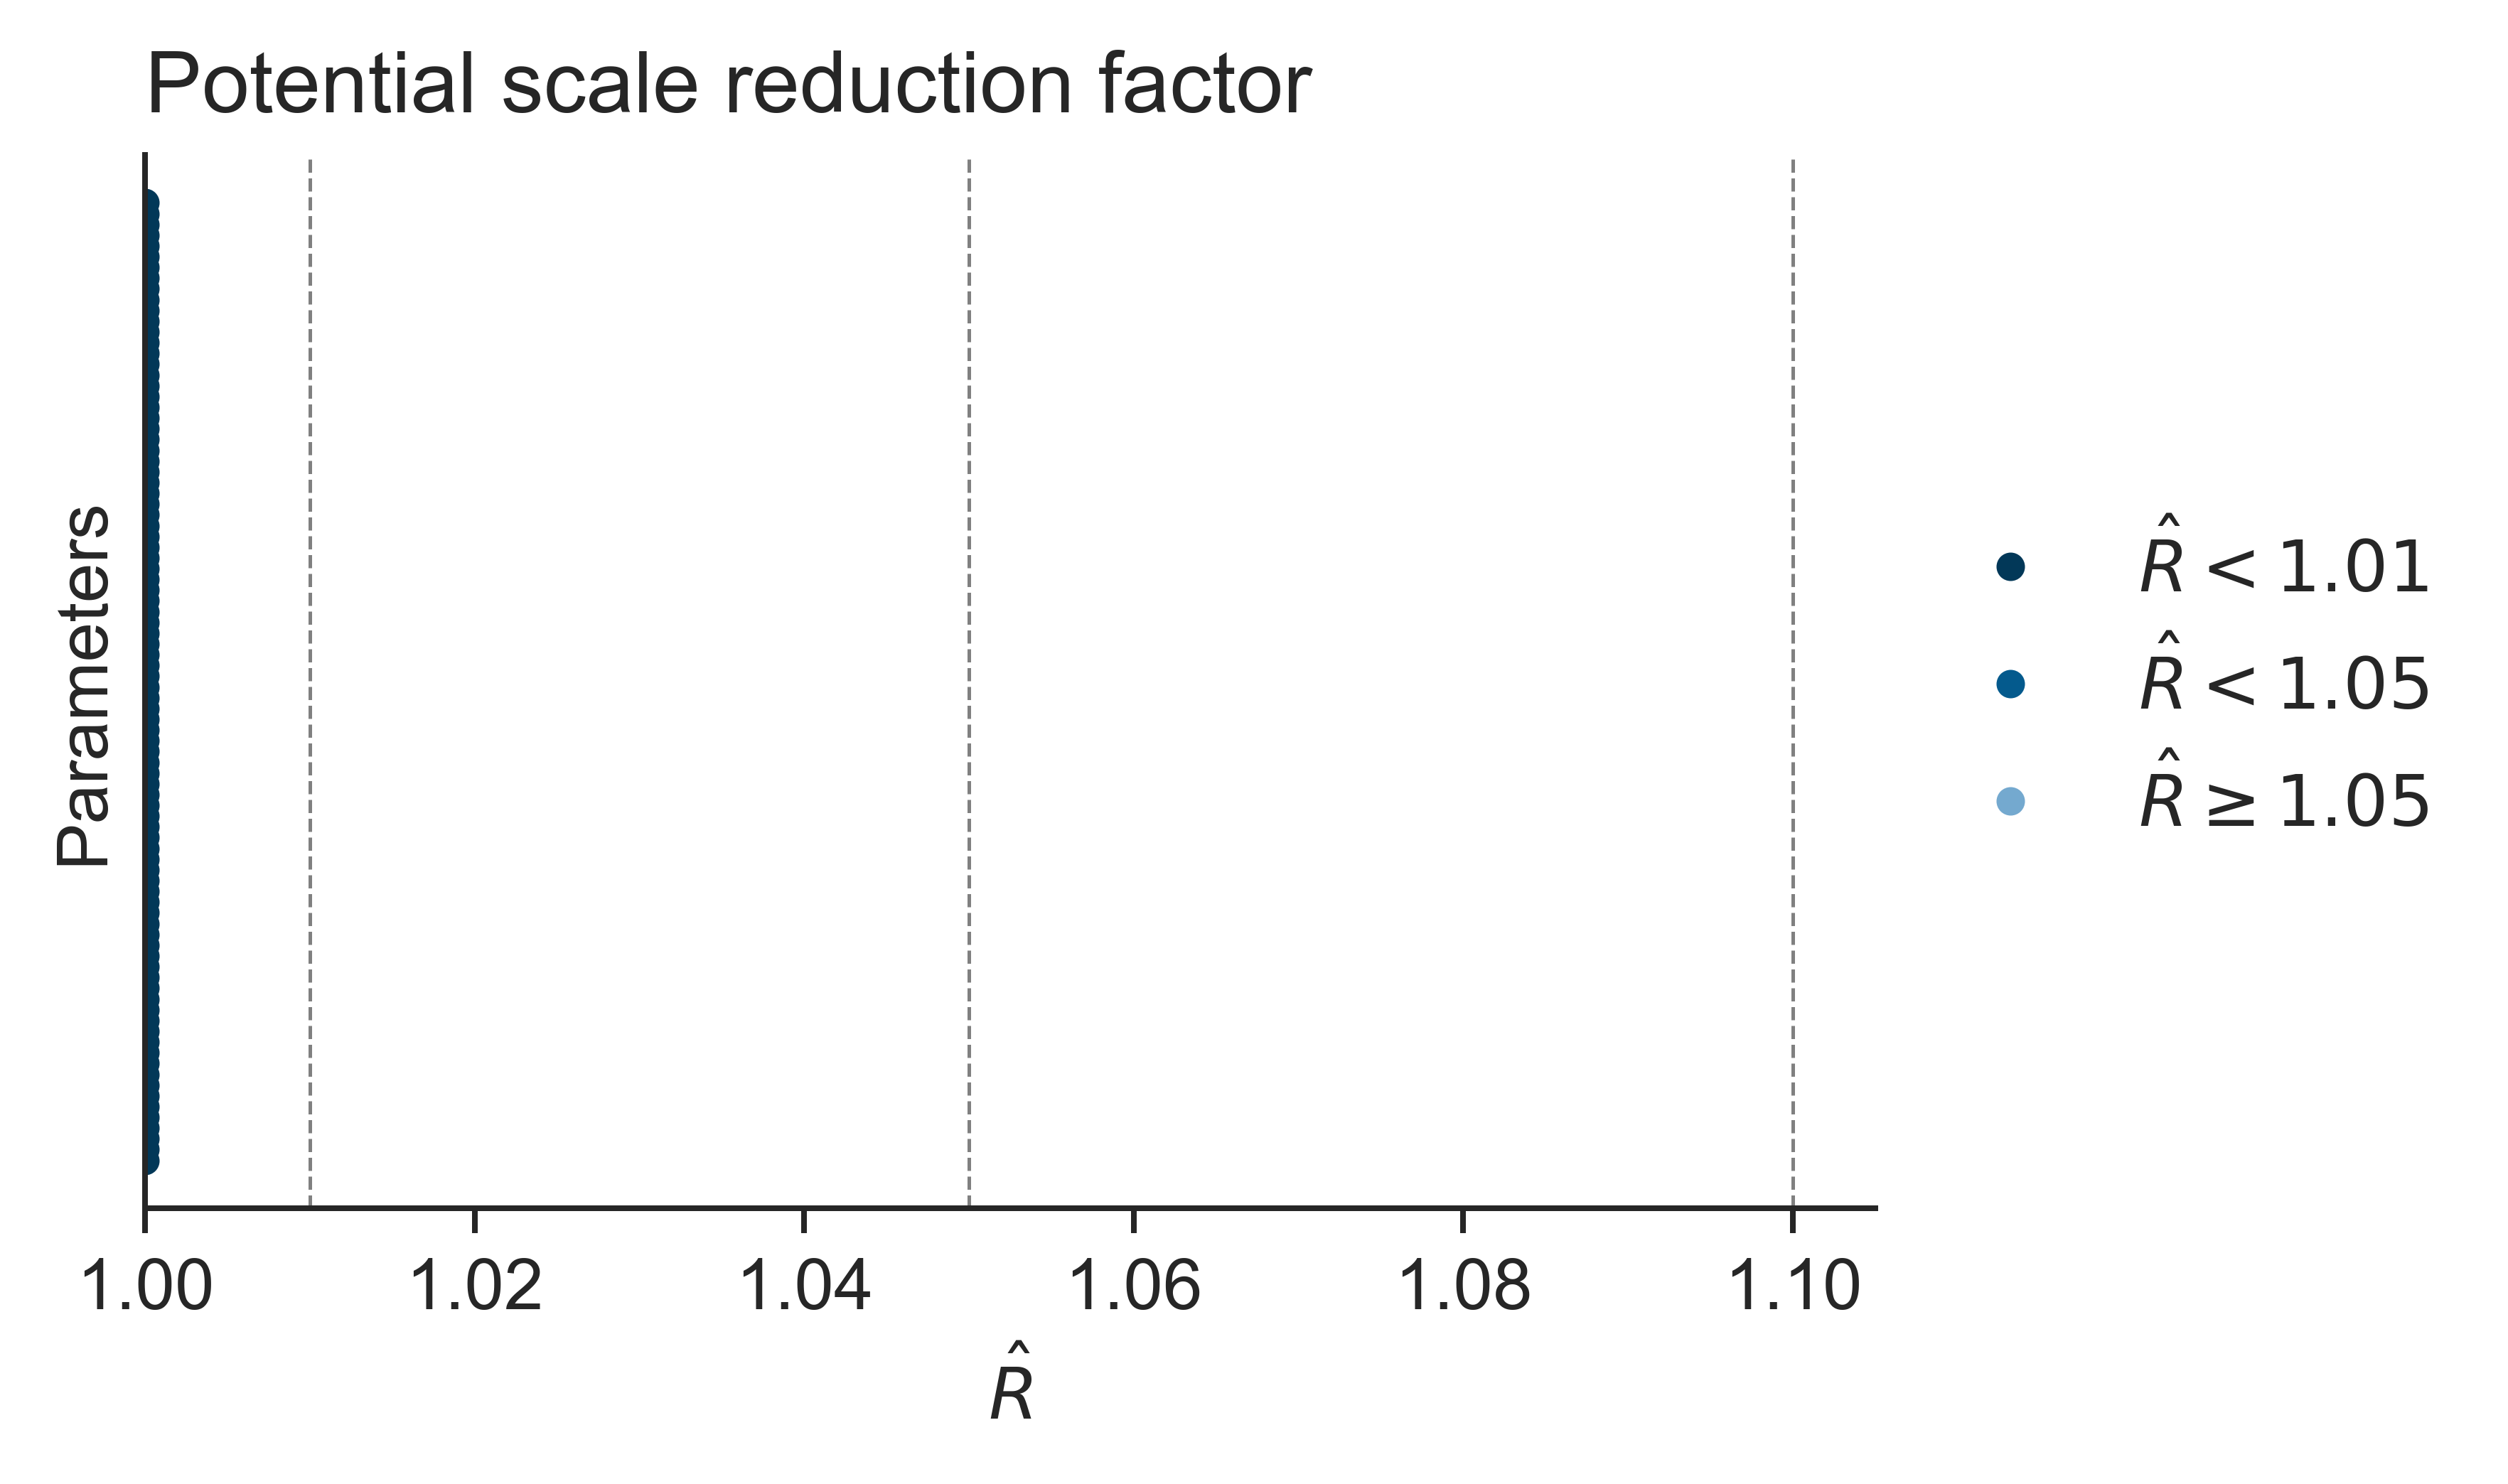

In [138]:
fig, ax = plot_rhat(trace2, "gamma")

In [139]:
fig.savefig("/Users/simondi/PHD/Sci/phd/presentations/2019_03_20_group_meeting/fig/posterior_rhat.svg")

In [142]:
model2, _, _ = shm(read_counts, True)

In [143]:
with model2:
    trace2 = pm.load_trace('/Users/simondi/PROJECTS/cell_line_project/results/shm/2019_03_18/shm_normalize/model_trace')

In [154]:
with model2:
    ppc_trace = pm.sample_posterior_predictive(trace2, 10000, random_seed=23)

100%|██████████| 10000/10000 [00:12<00:00, 786.74it/s]


In [155]:
def plot_posterior(readcounts ,ppc_trace):
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.hist(readcounts["counts"].values, bins=200, lw=2,
            density=True, edgecolor='black', histtype='step', label='Data')
    ax.hist(ppc_trace['x'][0,:], bins=200, density=True, lw=2,
            histtype='step', label='Posterior predictive distribution');
    ax.set_xlim([-.5, .5])
    ax.set_xlabel(r"Log fold-change")
    ax.set_ylabel(r"Density")
    ax.xaxis.set_label_coords(.95, -0.115)
    ax.yaxis.set_label_coords(-0.075, .95)
    ax.set_xlim([-1, 1])
    ax.legend(frameon=False)

    return fig, ax

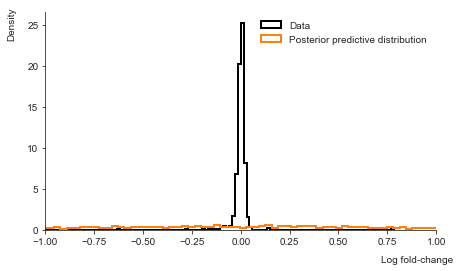

In [156]:
fig, ax = plot_posterior(read_counts, ppc_trace)

In [157]:
fig.savefig("/Users/simondi/PHD/Sci/phd/presentations/2019_03_20_group_meeting/fig/posterior_predictive.svg")